In [1]:
from __future__ import division
import sys
import numpy as np
import torch as th
import torch.autograd as ag
from torch import nn, optim

In [2]:
import csv
import nltk
import numpy as np
import re


In [4]:
!pip install gensim

    100% |################################| 15.9MB 28kB/s  eta 0:00:01
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/36/48/35/97efc2bd1b233627131c9a936c9de23681846db707b907d353
Successfully built smart-open


In [5]:
import gensim

In [37]:
def load_B_task_dataset(file_path):
    assert isinstance(file_path, str)  # Type check
    messages, polarities = [], []
    with open(file_path) as dataset_file:
        for instance in csv.reader(dataset_file, delimiter='\t'):
            context, message, polarity = instance[-3], instance[-1], instance[-2]
            messages.append(message)
            if polarity == 'negative':
                polarities.append(0)
            elif polarity == 'positive':
                polarities.append(2)
            else:
                polarities.append(1)
    return messages, polarities


def clean_digit(token):
    if re.search(r'.*\d.*', token): #whatever_digit_whatever
        return False
    return True


def clean_url(token):
    if re.search(r'\w+\.\w+', token): #word.word
        return False
    if not (token.startswith("http") or token.startswith("www")):
        return True
    return False


def clean_punc(token):
    punc = [".", ";", "!", ":", "(", ")", "[", "]", "?", ",", "&", "-", "$", "~", "#", "{", "}", "/", "\\", '\'', '\"', '<', '>', '`', "+", "|", "^","@","%","=","*"]
    if token in punc:
        return False
    if re.search(r'-+>', token): #----->
        return False
    if re.search(r'<-+', token): # <-----
        return False
    if re.search(r'\.+', token): #........
        return False
    if re.search(r'(\.\s)+\.', token): #. . . .
        return False
    if re.search(r':+', token): #:::::
        return False
    if re.search(r'\</?\w>', token): #Balises
        return False
    if re.match(r'_+', token): #____
        return False
    return True


def clean_tag(token):
    if re.search(r'@\w+', token): #@person , Emails
        return False
    return True


def clean_hashtag(token):
    if token.startswith("#"):
        hashtag = token[1:]
        #print("hashtag = "+ hashtag)
        hashtag_parts = []
        part = ""
        for c in hashtag:
            if(c.islower()):
                part += c
            else: #upper
                if(part != ""):
                    hashtag_parts.append(part)
                    part = ""+c
                else:
                    part = ""+c
        if (part != ""):
            hashtag_parts.append(part)
        #print("hashtag parts = "+ str(hashtag_parts))

    return token


def process_messages(raw_messages):  # For raw messages, each message is str
    from nltk.corpus import stopwords
    try:
        stop_words = set(stopwords.words())
    except LookupError:
        nltk.download('stopwords')
        stop_words = set(stopwords.words())
    assert isinstance(raw_messages, list) and all(isinstance(msg, str) for msg in raw_messages)  # Type check
    tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=True, strip_handles=True, reduce_len=True)
    tokened_messages = [tokenizer.tokenize(msg) for msg in raw_messages]
    clean_tokens = [[token for token in tokens if token not in stop_words and clean_url(token) and clean_digit(token) and clean_punc(token) and clean_tag(token)] for tokens in tokened_messages]
    no_hashtag_tokens = [[clean_hashtag(token) for token in tokens] for tokens in clean_tokens]
    return no_hashtag_tokens


def generate_vocabulary(processed_messages):  # For processed messages, each message is list of tokens
    assert isinstance(processed_messages, list) and all(isinstance(msg, list) for msg in processed_messages)  # Type check
    vocabulary = set()
    for message in processed_messages:
        vocabulary.update(message)
    return vocabulary


def get_indices(vocabulary):
    assert isinstance(vocabulary, set)
    words_indices = {}
    index = 0
    for word in vocabulary:
        words_indices[word] = index
        index += 1
    return words_indices


def transform_to_indices(processed_messages, words_indices):
    assert isinstance(processed_messages, list) and all(isinstance(msg, list) for msg in processed_messages)
    assert isinstance(words_indices, dict) and all(isinstance(v, int) for v in words_indices.values())  # Type check
    return [[words_indices[w] for w in msg] for msg in processed_messages]


In [38]:
data_file_train = 'B_train.dist'
messages, polarities = load_B_task_dataset(data_file_train)

data_file_dev = 'B_dev.dist'
messages_dev, polarities_dev = load_B_task_dataset(data_file_dev)

**Summary Statistics**

In [12]:
print(len(messages))
print(len(messages_dev))

#class distribution
import collections

counter_train=collections.Counter(polarities)
print("counter train : %s" %counter_train)
counter_dev=collections.Counter(polarities_dev)
print("counter dev : %s" %counter_dev)



5916
876
counter train : Counter({1: 2921, 2: 2179, 0: 816})
counter dev : Counter({1: 394, 2: 324, 0: 158})


In [16]:
print(messages[:5])

["Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)", "Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)", 'with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.', "Talking about ACT's && SAT's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.", "They may have a SuperBowl in Dallas, but Dallas ain't winning a SuperBowl. Not with that quarterback and owner. @S4NYC @RasmussenPoll"]


In [21]:
tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=True, strip_handles=True, reduce_len=True)
tokenizer.tokenize(messages[0])

[u'Gas',
 u'by',
 u'my',
 u'house',
 u'hit',
 u'$',
 u'3.39',
 u'!',
 u'!',
 u'!',
 u"I'm",
 u'going',
 u'to',
 u'Chapel',
 u'Hill',
 u'on',
 u'Sat',
 u'.',
 u':)']

In [24]:
pos_indices = [i for i, j in enumerate(polarities) if j == 2]
neg_indices = [i for i, j in enumerate(polarities) if j == 0]
neut_indices = [i for i, j in enumerate(polarities) if j == 1]

positives = [tokenizer.tokenize(messages[i]) for i in pos_indices]
negatives = [tokenizer.tokenize(messages[i]) for i in neg_indices]
neutrals = [tokenizer.tokenize(messages[i]) for i in neut_indices]

print(max([len(msg) for msg in positives]))
print(max([len(msg) for msg in negatives]))
print(max([len(msg) for msg in neutrals]))

print(min([len(msg) for msg in positives]))
print(min([len(msg) for msg in negatives]))
print(min([len(msg) for msg in neutrals]))

print(np.ceil(np.mean([len(msg) for msg in positives])))
print(np.ceil(np.mean([len(msg) for msg in negatives])))
print(np.ceil(np.mean([len(msg) for msg in neutrals])))



44
38
40
4
6
5
23.0
23.0
23.0


In [25]:
pos_indices = [i for i, j in enumerate(polarities_dev) if j == 2]
neg_indices = [i for i, j in enumerate(polarities_dev) if j == 0]
neut_indices = [i for i, j in enumerate(polarities_dev) if j == 1]

positives = [tokenizer.tokenize(messages_dev[i]) for i in pos_indices]
negatives = [tokenizer.tokenize(messages_dev[i]) for i in neg_indices]
neutrals = [tokenizer.tokenize(messages_dev[i]) for i in neut_indices]

print(max([len(msg) for msg in positives]))
print(max([len(msg) for msg in negatives]))
print(max([len(msg) for msg in neutrals]))

print(min([len(msg) for msg in positives]))
print(min([len(msg) for msg in negatives]))
print(min([len(msg) for msg in neutrals]))

print(np.ceil(np.mean([len(msg) for msg in positives])))
print(np.ceil(np.mean([len(msg) for msg in negatives])))
print(np.ceil(np.mean([len(msg) for msg in neutrals])))

35
34
38
7
8
6
23.0
23.0
22.0


In [39]:
p_messages = process_messages(messages)
p_messages_dev = process_messages(messages_dev)
vocab = generate_vocabulary(p_messages)

In [40]:
len(vocab)

17284

In [6]:
word_freq = {}
for w in vocab:
    word_freq[w] = 0
for msg in p_messages:
    for word in msg:
        word_freq[word]+=1

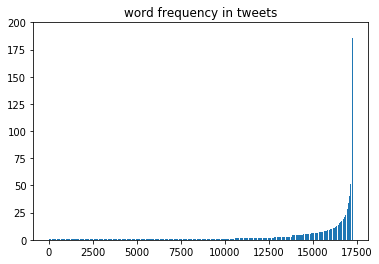

In [12]:
import matplotlib.pylab as plt
import seaborn as sns 
import operator
import math
%matplotlib inline
 
y = sorted(list(word_freq.values()))
x = list(range(len(y)))


low = min(y)
high = max(y)
plt.ylim([0, 200])
plt.bar(x, y)
plt.title('word frequency in tweets')
plt.show()

In [12]:
pos_indices = [i for i, j in enumerate(polarities) if j == 2]
neg_indices = [i for i, j in enumerate(polarities) if j == 0]
neut_indices = [i for i, j in enumerate(polarities) if j == 1]

positives = [p_messages[i] for i in pos_indices]
negatives = [p_messages[i] for i in neg_indices]
neutrals = [p_messages[i] for i in neut_indices]

print(max([len(msg) for msg in positives]))
print(max([len(msg) for msg in negatives]))
print(max([len(msg) for msg in neutrals]))

print(min([len(msg) for msg in positives]))
print(min([len(msg) for msg in negatives]))
print(min([len(msg) for msg in neutrals]))

print(np.ceil(np.mean([len(msg) for msg in positives])))
print(np.ceil(np.mean([len(msg) for msg in negatives])))
print(np.ceil(np.mean([len(msg) for msg in neutrals])))

22
20
22
3
3
3
12.0
13.0
12.0


**Modeling**

In [41]:
def create_vocabulary_embeddings(vocabulary, p_messages):
    
    embedding_size = 100
    model = gensim.models.Word2Vec(p_messages, min_count = 1, size = embedding_size)
    print (type(model))
    i=0
    vocabulary_embeddings = []
    embeddings_indices = {}
    for word in vocabulary:
        embedding = model[word]
        
        vocabulary_embeddings.append(embedding)
        embeddings_indices[word] = i
        i += 1
    vocabulary_embeddings = np.array(vocabulary_embeddings)
    return vocabulary_embeddings, embeddings_indices

In [42]:
vocabulary_embeddings,  embeddings_indices = create_vocabulary_embeddings(vocab, p_messages)

<class 'gensim.models.word2vec.Word2Vec'>


/home/nbuser/anaconda2_501/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [35]:
print(vocabulary_embeddings[0].shape)
print(vocabulary_embeddings[0])

(100,)
[  5.92030643e-04  -3.42225889e-04  -5.03302878e-03  -3.94049473e-03
  -1.24863276e-04  -4.21266258e-03   2.09194928e-04  -1.21670484e-03
  -2.52216851e-04  -3.49092181e-03   5.47816744e-03   4.21802630e-04
  -1.96429295e-03   1.38742290e-03   3.81470798e-03  -3.49098467e-03
   2.85565085e-03   1.69433898e-03   5.94719406e-03  -3.88491875e-03
   7.36129296e-04   3.86118609e-03  -3.84490751e-03  -3.98706133e-03
  -3.10851564e-03   2.63054064e-03  -2.26785964e-03  -7.17601448e-04
  -4.68426530e-04   2.31674267e-03  -2.76723877e-03   4.94276313e-03
   3.45109525e-04  -8.23360242e-05   3.69277713e-03   3.12332413e-03
  -3.55879311e-03  -1.30166567e-03  -1.05998683e-04  -4.33193706e-03
  -2.16496192e-04  -5.66866994e-03  -3.84996389e-03  -7.34965608e-04
  -3.04086017e-03  -4.62904852e-03   4.52505751e-03  -2.75416882e-03
   6.13566395e-03   3.24629829e-04   4.80645627e-04  -2.28602905e-03
  -9.38326353e-04   1.47350482e-03   1.27263868e-03  -8.89866264e-04
   2.11313623e-03   5.67394

In [46]:
X_train = np.zeros((len(p_messages), len(vocabulary_embeddings[0])))
messages_indices = transform_to_indices(p_messages, embeddings_indices)
for i,msg in enumerate(messages_indices):
    sum_emb = np.zeros(len(vocabulary_embeddings[0]))
    for word in msg:
        sum_emb += vocabulary_embeddings[word]
    X_train[i] = sum_emb

y_train = np.array(polarities)

In [47]:
print(X_train.shape)
print(y_train.shape)

(5916, 100)
(5916,)


In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)
clf = MLPClassifier(hidden_layer_sizes=(100,))
mean_acc = []
for train_indices, test_indices in skf.split(X_train, y_train):
    clf.fit(X_train[train_indices], y_train[train_indices])
    accuracy = clf.score(X_train[test_indices], y_train[test_indices])
    mean_acc.append(accuracy)
    print(accuracy)
print('mean accuracy: %.2f'%np.mean(mean_acc))

0.512647554806
0.540540540541
0.513513513514
0.521959459459
0.5
0.530405405405
0.521150592217
0.495769881557
0.48730964467
0.493220338983
mean accuracy: 0.51
